In [1]:
import numpy as np

from lib.data_preprocessing import remove_correlated_columns
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_offset_data_loader
from lib.model.classification_transformer import TransformerHyperParameters
from lib.transformer_training import train_transformer_with_cv, train_transformer, test_network
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.random import set_random_seed
import lib.torch_device as tdev
import torch.optim.lr_scheduler as lr_scheduler

%load_ext autoreload
%autoreload 2

In [2]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [3]:
data_train, labels_train, data_test, labels_test = split(*load_all_data('dataset'), seed=69420)

In [4]:
data_train, data_test = remove_correlated_columns(data_train, data_test)

In [5]:
data_train.shape

(960, 100, 268)

In [10]:
set_random_seed(42)
subset_indices = [
    bird * data_train.shape[0] // 6 + sample_nr
    for bird in range(6)
    for sample_nr in range(10)
]
# data_train_subset = data_train[subset_indices, :, :]
# labels_train_subset = labels_train[subset_indices, :]
data_train_subset = data_train[subset_indices, :, :]
labels_train_subset = labels_train[subset_indices, :]
print(data_train_subset.shape)
print(labels_train_subset.shape)

(60, 100, 268)
(60, 100)


## Hyper Parameter

In [7]:
## Default
hyper_parameters = TransformerHyperParameters(
    d_model=512,
    nhead=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
    dim_feedforward=2048,
    dropout=0.1,
    out_size=NUM_CLASSES,
    in_features=data_train.shape[-1],
)
## Current
hyper_parameters = TransformerHyperParameters(
    d_model=128,
    nhead=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
    dim_feedforward=1024,
    dropout=0.1,
    out_size=NUM_CLASSES,
    in_features=data_train.shape[-1],
)

In [8]:
training_hyper_parameters = TrainingHyperParameters(
    batch_size=128,
    num_epochs=150,
    lr=1e-2,
    lr_scheduler_provider=lambda optimizer: lr_scheduler.MultiStepLR(
        optimizer, 
        milestones=[10, 30, 60, 100], 
        gamma=0.1
    )
)

## Training

In [18]:
set_random_seed(42)

train_transformer_with_cv(
    data_train_subset, 
    labels_train_subset, 
    hyper_parameters, 
    training_hyper_parameters, 
    device
)

np.min(labels) = 0.0
torch.flatten(torch.Tensor(labels).long()).min() = tensor(0)


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 8.00 GiB total capacity; 7.04 GiB already allocated; 0 bytes free; 7.30 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [11]:
set_random_seed(42)

transformer = train_transformer(
    data_train_subset, 
    labels_train_subset, 
    hyper_parameters, 
    training_hyper_parameters, 
    device
)

np.min(labels) = 0.0
torch.flatten(torch.Tensor(labels).long()).min() = tensor(0)
loss_weight = tensor([ 1.0000,  9.9554,  6.6479,  8.8590, 38.6731, 20.2111, 18.9717],
       device='cuda:0')
Epoch  0: epoch_loss = 2.262574, num_correct =  3512, num_samples =  6000, acc = 0.585333, bacc = 0.126696
Epoch  1: epoch_loss = 2.969042, num_correct =   104, num_samples =  6000, acc = 0.017333, bacc = 0.134777
Epoch  2: epoch_loss = 3.069208, num_correct =   347, num_samples =  6000, acc = 0.057833, bacc = 0.136290
Epoch  3: epoch_loss = 2.635720, num_correct =   217, num_samples =  6000, acc = 0.036167, bacc = 0.137319
Epoch  4: epoch_loss = 2.376815, num_correct =   600, num_samples =  6000, acc = 0.100000, bacc = 0.138365
Epoch  5: epoch_loss = 2.110154, num_correct =   577, num_samples =  6000, acc = 0.096167, bacc = 0.138940
Epoch  6: epoch_loss = 2.001911, num_correct =   107, num_samples =  6000, acc = 0.017833, bacc = 0.139686
Epoch  7: epoch_loss = 2.068061, num_correct =  3294, num_s

tensor([2, 2, 2,  ..., 2, 2, 2], device='cuda:0') tensor([0, 0, 0,  ..., 1, 1, 0], device='cuda:0')
tensor([2, 2, 2,  ..., 2, 2, 2], device='cuda:0') tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tensor([2, 2, 2,  ..., 2, 2, 2], device='cuda:0') tensor([0, 0, 0,  ..., 0, 0, 3], device='cuda:0')
tensor([2, 2, 2,  ..., 2, 2, 2], device='cuda:0') tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tensor([2, 2, 2,  ..., 2, 2, 2], device='cuda:0') tensor([0, 0, 0,  ..., 0, 4, 0], device='cuda:0')
tensor([2, 2, 2,  ..., 2, 2, 2], device='cuda:0') tensor([0, 0, 0,  ..., 5, 0, 5], device='cuda:0')
tensor([2, 2, 2,  ..., 2, 2, 2], device='cuda:0') tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tensor([2, 2, 2,  ..., 2, 2, 2], device='cuda:0') tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
Evaluated with loss = 0.0006819420357545217, acc = 0.07595833333333334, bacc = 0.14285714285714285


<Figure size 1440x1440 with 0 Axes>

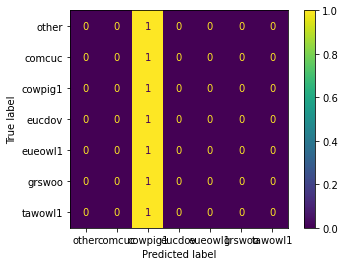

In [12]:
# test_loader = create_offset_data_loader(np.random.normal(size=(240, 100, 268)), np.random.randint(0, 7, size=(240, 100)))
test_loader = create_offset_data_loader(data_test, labels_test)
test_network(transformer, test_loader, device)